## Training and tracking an XGBoost classifier with MLflow

This notebook demonstrates how to use MLflow for tracking experiment using MLflow in Azure ML. We will consider the Heart Disease Data Set. This database contains 76 attributes, but we will be using a subset of 14 of them. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. In this example we will concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

**Note**: *requirements.txt* contains the packages needed to run this notebook contents. Python 3.11.9 was used.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import mlflow

mlflow.set_experiment(experiment_name="heart-condition-classifier")

<Experiment: artifact_location='file:///Users/mridul/deeplearning/mlflow/training/mlruns/370912703705039286', creation_time=1718258265516, experiment_id='370912703705039286', last_update_time=1718258265516, lifecycle_stage='active', name='heart-condition-classifier', tags={}>

In [3]:
import pandas as pd

file_url = "https://azuremlexampledata.blob.core.windows.net/data/heart-disease-uci/data/heart.csv"
df = pd.read_csv(file_url)

df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,normal,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,normal,1
7,57,0,4,120,354,0,0,163,1,0.6,1,0,normal,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,reversible,1
9,53,1,4,140,203,1,2,155,1,3.1,3,0,reversible,0


In [4]:
print(df["thal"].unique())

# col 'thal' is categorical. Check how many values are present and convert to categorical
df["thal"] = df["thal"].astype("category").cat.codes

['fixed' 'normal' 'reversible' '1' '2']


In [5]:
# Let's split our dataset in train and test, so we can assess the performance of the model without overfitting the dataset.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1), df["target"], test_size=0.3
)

### Training a model

We are going to use autologging capabilities in MLflow to track parameters and metrics:

In [6]:
mlflow.xgboost.autolog()

In [7]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

In [8]:
# As soon as the train method is executed, MLflow will stat a run in Azure ML to start tracking the experiment's run. 
# However, it is always a good idea to start the run manually so you have the run ID at hand quickly. This is not required though.
run = mlflow.start_run()
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Logging extra metric

In [9]:
y_pred = model.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 78.02%
Recall: 65.22%


### Exploring the expriment with MLFlow

In [11]:
mlflow.end_run()

In [12]:
run = mlflow.get_run(run.info.run_id)

In [13]:
pd.DataFrame(data=[run.data.params], index=["Value"]).T

,Value
reg_lambda,None
custom_metric,None
colsample_bynode,None
gamma,None
multi_strategy,None
validate_parameters,None
max_cat_threshold,None
max_delta_step,None
monotone_constraints,None
colsample_bylevel,None


In [14]:
pd.DataFrame(data=[run.data.metrics], index=["Value"]).T

,Value
validation_0-logloss,0.670785
accuracy_score_X_test,0.780220
recall_score_X_test,0.652174


Let's explore artifacts that got logged in the run. This requires to use the MLflow client:

In [15]:
client = mlflow.tracking.MlflowClient()
client.list_artifacts(run_id=run.info.run_id)

[<FileInfo: file_size=189, is_dir=False, path='feature_importance_weight.json'>,
 <FileInfo: file_size=23567, is_dir=False, path='feature_importance_weight.png'>,
 <FileInfo: file_size=148, is_dir=False, path='metric_info.json'>,
 <FileInfo: file_size=None, is_dir=True, path='model'>]

As you can see in this example, three artifacts are availble in the run:

- feature_importance_weight.json -> the feature importance of the model we created.
- feature_importance_weight.png -> a plot of the feature importance mentioned above, stored as an image.
- metric_info.json -> contains a json representation of all the metrics captured by the XGBoost.
- model, the path where the model is stored. Note that this artifact is a directory.

In [16]:
file_path = mlflow.artifacts.download_artifacts(
    run_id=run.info.run_id, artifact_path="feature_importance_weight.png"
)

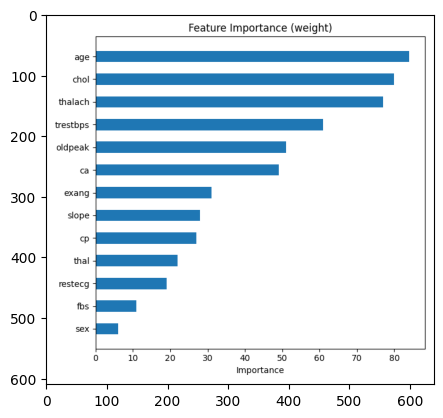

In [17]:
# Given it is an image, we can show it with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(file_path)
plt.imshow(image)
plt.show()

### Logging models with preprocessing

As can be seen, MLflow automatically logs models, but some times we need to log a different model, specially when we are doing preprocessing. In this example we did some categorical encoding, so our model right now expects the values of the column 'thal' to be integers, not strings.

To handle that requirement that requirement go away, we can create a Pipeline object with Scikit-Learn and log that model instead of the one automatically logged for us.

In [18]:
# Reload the dataset
df = pd.read_csv(file_url)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("target", axis=1), df["target"], test_size=0.3
)

In [20]:
#User ordinal encoder instead of categorical encoder

import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Step 1. Create a column transformer instance for the column 'thal'
encoder = ColumnTransformer(
    [
        (
            'cat_encoding',
            OrdinalEncoder(categories='auto', encoded_missing_value=np.nan),
            ['thal']
        )
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Step 2. Create a model instance
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Step 3. Create a pipeline
pipeline = Pipeline(steps=[("encoding",encoder),("model",model)])
pipeline

Pipeline(steps=[('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_encoding',
                                                  OrdinalEncoder(), ['thal'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categori...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

We need to handle the expected signature of the model. Signatures are use by MLflow to know what type of inputs are expected for a given model. This allows the model builder to be explicit about which types are being expected. 

In the first model we logged, all inputs needed to be numeric, including the column 'thal'. However, our new pipeline can encode this values automatically so we can take 'thal' values in string format.

In [21]:
from mlflow.models import infer_signature

signature = infer_signature(X_test, y_test)
signature

inputs: 
  ['age': long (required), 'sex': long (required), 'cp': long (required), 'trestbps': long (required), 'chol': long (required), 'fbs': long (required), 'restecg': long (required), 'thalach': long (required), 'exang': long (required), 'oldpeak': double (required), 'slope': long (required), 'ca': long (required), 'thal': string (required)]
outputs: 
  ['target': long (required)]
params: 
  None

### Train the pipeline

In [22]:
with mlflow.start_run() as run:
    pipeline.fit(X_train, y_train)
    mlflow.sklearn.log_model(pipeline, artifact_path="pipeline", signature=signature)

In [23]:
# Load the model back
pipeline_model = mlflow.sklearn.load_model(f"runs:/{run.info.run_id}/pipeline")
type(pipeline_model)

sklearn.pipeline.Pipeline

In [24]:
# Make a prediction on the pipeline with categorical data
pipeline_model.predict(X_test)

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0])